In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [24]:
data_path = "hin.txt"   
num_samples = 30000     
input_texts, target_texts = [], []
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[:num_samples]:
    if "\t" not in line: continue
    eng, hin, _ = line.split("\t")
    input_texts.append(eng)
    target_texts.append("<start> " + hin + " <end>")

In [25]:
max_vocab_size = 20000
eng_tokenizer = Tokenizer(num_words=max_vocab_size, filters='')
eng_tokenizer.fit_on_texts(input_texts)
eng_seqs = eng_tokenizer.texts_to_sequences(input_texts)
max_encoder_len = max(len(s) for s in eng_seqs)
encoder_input_data = pad_sequences(eng_seqs, maxlen=max_encoder_len, padding='post')
hin_tokenizer = Tokenizer(num_words=max_vocab_size, filters='')
hin_tokenizer.fit_on_texts(target_texts)
hin_seqs = hin_tokenizer.texts_to_sequences(target_texts)
max_decoder_len = max(len(s) for s in hin_seqs)
decoder_input_data = pad_sequences(hin_seqs, maxlen=max_decoder_len, padding='post')
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
eng_vocab_size = min(max_vocab_size, len(eng_tokenizer.word_index) + 1)
hin_vocab_size = min(max_vocab_size, len(hin_tokenizer.word_index) + 1)
print("English vocab:", eng_vocab_size, "Hindi vocab:", hin_vocab_size)

English vocab: 3415 Hindi vocab: 3311


In [26]:
def build_model(cell_type="lstm", latent_dim=256):
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs)
    if cell_type == "lstm":
        encoder_outputs, state_h, state_c = LSTM(latent_dim, return_sequences=True, return_state=True)(enc_emb)
        encoder_states = [state_h, state_c]
    else:
        encoder_outputs, state_h = GRU(latent_dim, return_sequences=True, return_state=True)(enc_emb)
        encoder_states = [state_h]
    decoder_inputs = Input(shape=(None,))
    dec_emb = Embedding(hin_vocab_size, latent_dim)(decoder_inputs)
    if cell_type == "lstm":
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    else:
        decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
        decoder_outputs, _ = decoder_gru(dec_emb, initial_state=encoder_states)
    attention = Attention()
    context = attention([decoder_outputs, encoder_outputs])
    decoder_combined = tf.concat([decoder_outputs, context], axis=-1)
    decoder_dense = Dense(hin_vocab_size, activation="softmax")
    decoder_outputs = decoder_dense(decoder_combined)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [28]:
def train_and_save(cell_type="lstm", epochs=20, batch_size=64, latent_dim=256):
    model = build_model(cell_type, latent_dim)
    history = model.fit(
        [encoder_input_data, decoder_input_data],
        np.expand_dims(decoder_target_data, -1),  
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )
    os.makedirs("models_word", exist_ok=True)
    model.save(f"models_word/{cell_type}_model.h5")
    return model, history

In [29]:
def translate_sentence(sentence, model, cell_type="lstm", max_len=30):
    seq = eng_tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_encoder_len, padding='post')
    # Start with <start>
    target_seq = np.zeros((1, max_len))
    target_seq[0,0] = hin_tokenizer.word_index['<start>']
    decoded = []
    for i in range(1, max_len):
        preds = model.predict([seq, target_seq], verbose=0)
        word_index = np.argmax(preds[0,i-1,:])
        word = hin_tokenizer.index_word.get(word_index, '')
        if word == "<end>" or word == '':
            break
        decoded.append(word)
        target_seq[0,i] = word_index
    return " ".join(decoded)

In [30]:
model_lstm, hist_lstm = train_and_save("lstm", epochs=30, latent_dim=512)


Epoch 1/30


2025-09-25 09:03:07.494558: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


39/39 [==============================] - 5s 92ms/step - loss: 2.3715 - accuracy: 0.7255 - val_loss: 2.9830 - val_accuracy: 0.5965
Epoch 2/30


2025-09-25 09:03:11.339202: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


39/39 [==============================] - 3s 65ms/step - loss: 1.5353 - accuracy: 0.7636 - val_loss: 2.7453 - val_accuracy: 0.6236
Epoch 3/30
39/39 [==============================] - 1s 33ms/step - loss: 1.4412 - accuracy: 0.7802 - val_loss: 2.6830 - val_accuracy: 0.6326
Epoch 4/30
39/39 [==============================] - 1s 28ms/step - loss: 1.3590 - accuracy: 0.7856 - val_loss: 2.6773 - val_accuracy: 0.6376
Epoch 5/30
39/39 [==============================] - 1s 29ms/step - loss: 1.3158 - accuracy: 0.7922 - val_loss: 2.6512 - val_accuracy: 0.6426
Epoch 6/30
39/39 [==============================] - 1s 31ms/step - loss: 1.2792 - accuracy: 0.7941 - val_loss: 2.6391 - val_accuracy: 0.6446
Epoch 7/30
39/39 [==============================] - 1s 21ms/step - loss: 1.2399 - accuracy: 0.7975 - val_loss: 2.6414 - val_accuracy: 0.6464
Epoch 8/30
39/39 [==============================] - 1s 24ms/step - loss: 1.2002 - accuracy: 0.7993 - val_loss: 2.5920 - val_accuracy: 0.6486
Epoch 9/30
39/39 [======

In [31]:
print("English:", "How are you?")
print("Hindi:", translate_sentence("How are you?", model_lstm, "lstm"))

English: How are you?
Hindi: आप कैसे हो?


2025-09-25 09:03:47.806203: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [32]:
model_gru, hist_gru = train_and_save("gru", epochs=30, latent_dim=512)


Epoch 1/30


2025-09-25 09:03:57.848797: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


39/39 [==============================] - 4s 73ms/step - loss: 2.5426 - accuracy: 0.7251 - val_loss: 2.7842 - val_accuracy: 0.5949
Epoch 2/30


2025-09-25 09:04:00.864797: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


39/39 [==============================] - 2s 40ms/step - loss: 1.5135 - accuracy: 0.7587 - val_loss: 2.7281 - val_accuracy: 0.6003
Epoch 3/30
39/39 [==============================] - 1s 30ms/step - loss: 1.4269 - accuracy: 0.7757 - val_loss: 2.6622 - val_accuracy: 0.6195
Epoch 4/30
39/39 [==============================] - 1s 24ms/step - loss: 1.3570 - accuracy: 0.7828 - val_loss: 2.6619 - val_accuracy: 0.6309
Epoch 5/30
39/39 [==============================] - 1s 21ms/step - loss: 1.2950 - accuracy: 0.7892 - val_loss: 2.6148 - val_accuracy: 0.6369
Epoch 6/30
39/39 [==============================] - 1s 22ms/step - loss: 1.2442 - accuracy: 0.7942 - val_loss: 2.6299 - val_accuracy: 0.6404
Epoch 7/30
39/39 [==============================] - 1s 18ms/step - loss: 1.1965 - accuracy: 0.7971 - val_loss: 2.6511 - val_accuracy: 0.6414
Epoch 8/30
39/39 [==============================] - 1s 18ms/step - loss: 1.1490 - accuracy: 0.7997 - val_loss: 2.6627 - val_accuracy: 0.6438
Epoch 9/30
39/39 [======

2025-09-25 09:04:23.877056: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3060" frequency: 1777 num_cores: 28 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2359296 shared_memory_size_per_multiprocessor: 102400 memory_size: 1237057536 bandwidth: 360048000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [35]:
print("English:", "How are you?")
print("Hindi (GRU):", translate_sentence("How are you?", model_gru, "gru"))

English: How are you?
Hindi (GRU): तुम कैसी हो?


In [34]:

train_acc_lstm = hist_lstm.history['accuracy'][-1]
val_acc_lstm = hist_lstm.history['val_accuracy'][-1]

train_acc_gru = hist_gru.history['accuracy'][-1]
val_acc_gru = hist_gru.history['val_accuracy'][-1]

print("=== Model Accuracy Comparison ===")
print(f"LSTM -> Train Accuracy: {train_acc_lstm:.4f}, Validation Accuracy: {val_acc_lstm:.4f}")
print(f"GRU  -> Train Accuracy: {train_acc_gru:.4f}, Validation Accuracy: {val_acc_gru:.4f}")


=== Model Accuracy Comparison ===
LSTM -> Train Accuracy: 0.9674, Validation Accuracy: 0.6701
GRU  -> Train Accuracy: 0.9864, Validation Accuracy: 0.6686


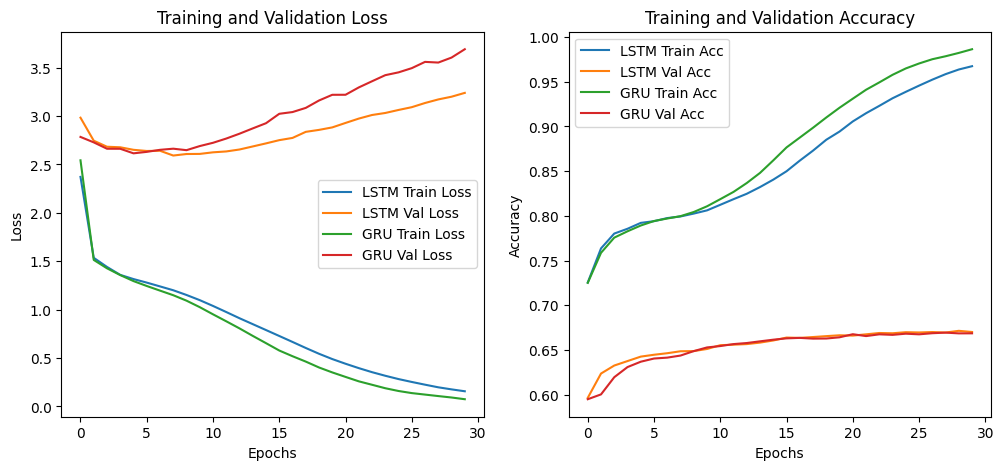

In [33]:
import matplotlib.pyplot as plt
def plot_history(hist_lstm, hist_gru):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist_lstm.history['loss'], label='LSTM Train Loss')
    plt.plot(hist_lstm.history['val_loss'], label='LSTM Val Loss')
    plt.plot(hist_gru.history['loss'], label='GRU Train Loss')
    plt.plot(hist_gru.history['val_loss'], label='GRU Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist_lstm.history['accuracy'], label='LSTM Train Acc')
    plt.plot(hist_lstm.history['val_accuracy'], label='LSTM Val Acc')
    plt.plot(hist_gru.history['accuracy'], label='GRU Train Acc')
    plt.plot(hist_gru.history['val_accuracy'], label='GRU Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(hist_lstm, hist_gru)
